In [18]:
import matplotlib.pyplot as plt
import rasterio.plot

In [19]:
plt.rcParams["figure.figsize"] = [10,6]  # Set default figure size
%config InlineBackend.figure_format = 'retina'

## Handler

In [20]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point

precision = 5 # precision of input coordinates, 5dec~=1.1m

class GISHandler:
    """A class to handle GIS raster data and optimizer points."""
        
    def __init__(self, files):
        """Initializes handler by creating a GeoDataFrame to store point measurement data and a dictionary of loaded raster files."""
        self.rasters = {}
        self.points = gpd.GeoDataFrame(columns=['x', 'y', 'result', 'geometry'], geometry='geometry')
        
        for key, src in files.items():
            if key in self.rasters:
                print('raster {} already loaded!'.format(key))
            else:
                self.rasters[key] = rasterio.open(src)
    
    def query(self, x, y):
        """Gets condition data for a specified geography location (lon/lat), stores it in the GeoDataFrame, and returns the row."""
        x, y = self.coordinate(x, y)
                                    
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            print('point exists, returning original data')
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y)}
        
        for key, raster in self.rasters.items():
            index = raster.index(x, y)
            try:
                 conditions[key] = raster.read(1)[index] # yes, by default this only reads the first band, but this is probably okay
            except IndexError as error:
                print('failed to read {} raster: {}'.format(key, error))    
        
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def record(self, x, y, value):
        """Records a computed value from the optimizer to a geographic point, returns row recorded to."""
        x, y = self.coordinate(x, y)
        
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            self.points.loc[(self.points.x==x) & (self.points.y==y), 'result'] = value
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y), 'result': value}
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]       
        
    def coordinate(self, x, y):
        """Rounds coordinates to given precision to prevent uneccessary duplication, in the future may handle projections."""
        return round(x, precision), round(y, precision)

## Example

In [21]:
raster_files = {'current': 'data/surface-current-ms.tif',
                'oxygen': 'data/surface-oxygen-mgpl.tif',
                'salinity': 'data/surface-salinity-psu.tif',
                'temperature': 'data/surface-temperature-c.tif'}
handler = GISHandler(raster_files)

In [22]:
handler.query(-70, 41)

C:\Users\Arezoo_Admin\AppData\Local\Temp\ipykernel_10932\3096882756.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.points = self.points.append(conditions, ignore_index=True)
C:\Users\Arezoo_Admin\AppData\Local\Programs\miniconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,result,geometry,current,oxygen,salinity,temperature
0,-70,41,NaN,POINT (-70.00000 41.00000),0.037624,9.332181,31.834198,10.765879


In [6]:
handler.record(-70, 41, 43)

,x,y,result,geometry,current,oxygen,salinity,temperature
0,-70,41,43,POINT (-70.00000 41.00000),0.037624,9.332181,31.834198,10.765879


In [15]:
handler.query(-68.323232323131213, 40.1231223)
handler.points

C:\Users\Arezoo_Admin\AppData\Local\Temp\ipykernel_10932\3096882756.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.points = self.points.append(conditions, ignore_index=True)
C:\Users\Arezoo_Admin\AppData\Local\Programs\miniconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,result,geometry,current,oxygen,salinity,temperature
0,-70,41,43,POINT (-70.00000 41.00000),0.037624,9.332181,31.834198,10.765879
1,-68,40,NaN,POINT (-68.00000 40.00000),0.096250,8.605487,34.263721,15.900171
2,-68,40.12312,NaN,POINT (-68.00000 40.12312),0.094234,8.717808,33.924660,15.312290
3,-68.32323,40.12312,NaN,POINT (-68.32323 40.12312),0.216164,8.768057,33.979309,14.752655


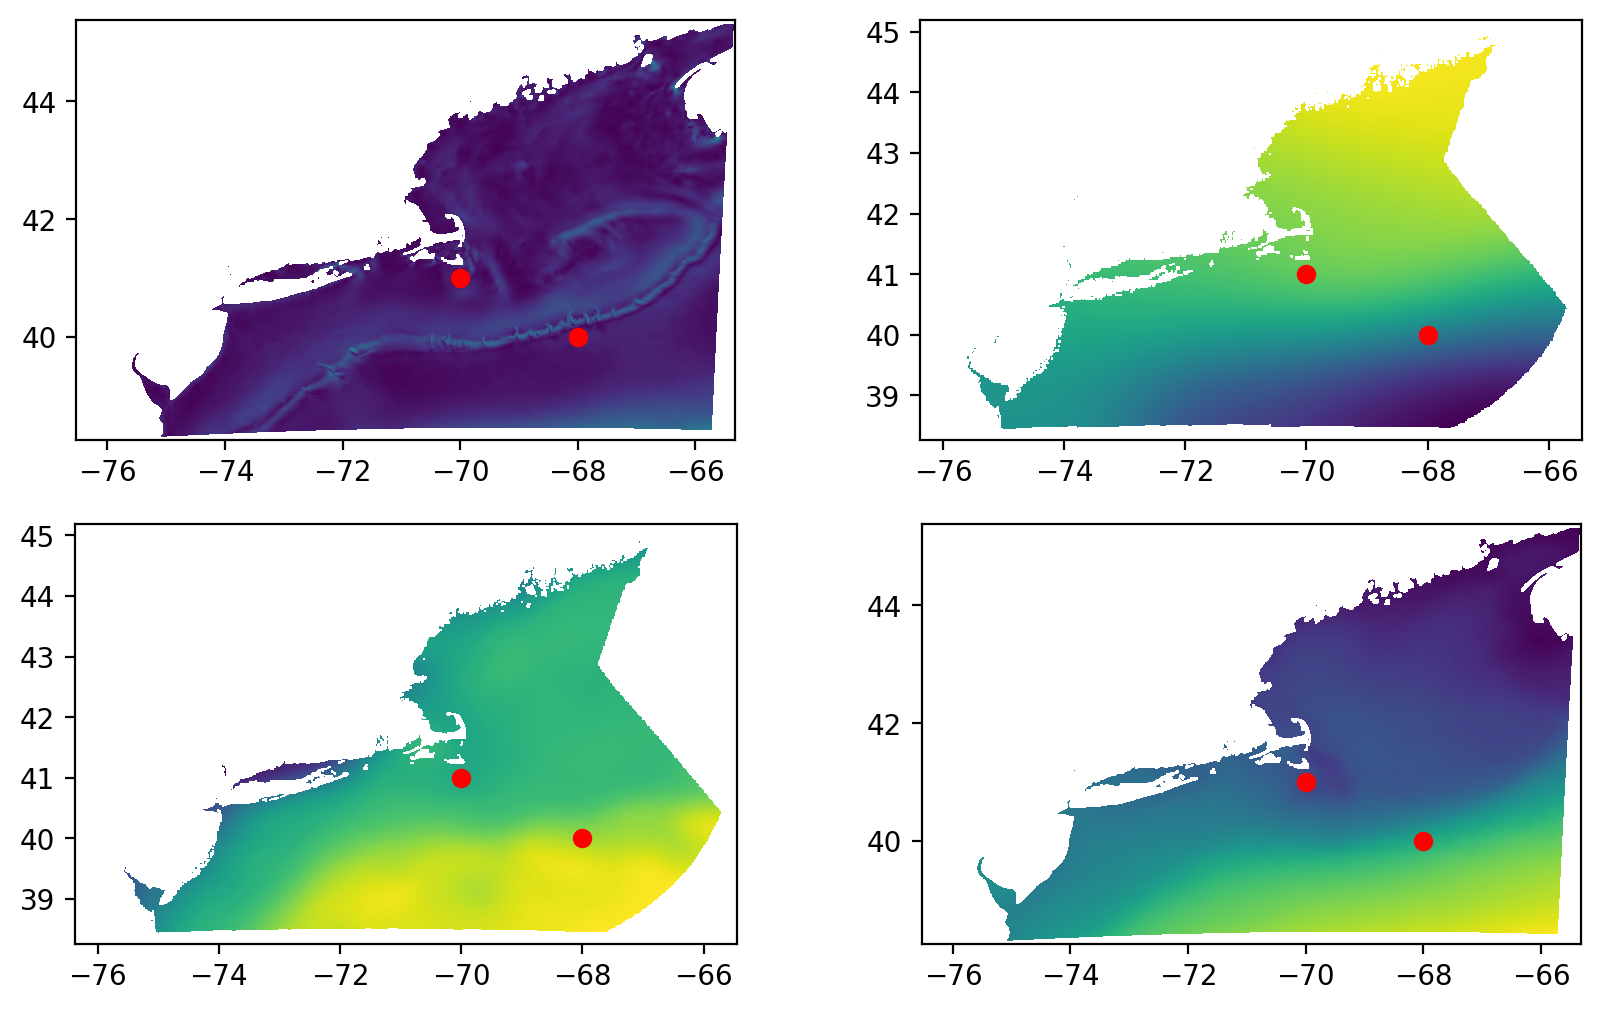

In [8]:
fig, ax = plt.subplots(2, 2)
rasterio.plot.show(handler.rasters['current'], ax=ax[0,0])
rasterio.plot.show(handler.rasters['oxygen'], ax=ax[0,1])
rasterio.plot.show(handler.rasters['salinity'], ax=ax[1,0])
rasterio.plot.show(handler.rasters['temperature'], ax=ax[1,1])

for i in ax:
    for j in i:
        handler.points.plot(ax=j, color='red')

In [13]:
handler.points.explore()